# Домашнее задание: Деревья. Случайный лес

Правила:

- Домашнее задание оценивается в 10 баллов (+1 бонусный балл).


- Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.


- Можно использовать любые свободные источники с обязательным указанием ссылки на них.


- Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.

<!-- ![](meme.jpg) -->
<img src="meme.jpg" alt="Drawing" style="width: 700px;"/>

## Часть 1: Основы построения решающего дерева (1.5 балла)

В этой части все расчёты необходимо реализовывать в виде запрограммированных формул, например, на `numpy`. **Нельзя использовать готовые реализации**. Например, если в задании требуется рассчитать энтропию, то требуется в каком-то виде релизовать расчёт по формуле, но нельзя использовать готовую реализацию `some_module.entropy()`.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

**Задание 1.1 (0.5 балла)** Пусть известно, что в вершину решающего дерева попали 10 объектов, 8 из которых имеют метку класса $k_1$, а 2 имеют метку класса $k_2$. Рассчитайте энтропию такого распределения классов (с натуральным логарифмом). Ответ округлите до двух знаков после запятой.

In [10]:
objects = np.array([8, 2])
probs = objects / np.sum(objects)
entropy = -np.sum(probs * np.log(probs))

print(f"Энтропия: {round(entropy, 2)}")

Энтропия: 0.5


**Задание 1.2 (0.5 балла)** Пусть дополнительно известно, что вершина из предыдущего задания не является листовой и возможно такое разбиение, что в левое поддерево попадут все объекты класса $k_1$, а в правое - класса $k_2$. Посчитайте критерий информативности:

$$
Q(R_m, j, t) = H(R_m) - \frac{|R_\ell|}{|R_m|}H(R_\ell) - \frac{|R_r|}{|R_m|}H(R_r),
$$

где $R_m$ - множество объектов в разбиваемой вершине, $j$ - номер признака, по которому происходит разбиение, $t$ - порог разбиения, $R_\ell$ - множество объектов в левом поддереве, $R_r$ - множество объектов в правом поддереве.

Теперь в качестве $H(R)$ будем использовать индекс Джини:

$$
H(R) = \sum_{k=1}^J p_k(1-p_k),
$$
где $J$ – общее количество классов (в нашем случае, $J = 2$).

Ответ округлите до двух знаков после запятой.

In [11]:
def gini_index(objects):
    probs = objects / np.sum(objects)
    return np.sum(probs * (1 - probs))

counts_m = np.array([8, 2])
counts_l = np.array([8, 0])
counts_r = np.array([0, 2])
size_m = np.sum(counts_m)
size_l = np.sum(counts_l)
size_r = np.sum(counts_r)

Q = gini_index(counts_m) - (size_l / size_m) * gini_index(counts_l) - (size_r / size_m) * gini_index(counts_r)
print(f"Критерий информативности: {round(Q, 2)}")

Критерий информативности: 0.32


**Задание 1.3 (0.5 балла)** Пусть при построении дерева образовалась листовая вершина с 10 объектами, значения целевой переменной для которых следующие: [1, 10, 5, 18, 100, 30, 50, 61, 84, 47] (решается задача регрессии). Чему будут равны предсказания модели для этих объектов?

In [12]:
values = [1, 10, 5, 18, 100, 30, 50, 61, 84, 47]
print(f"Предсказание модели: {np.mean(values)}")

Предсказание модели: 40.6


## Часть 2: Решающие деревья (4.5 балла)

В этой части мы напишем и протестируем собственную реализацию решающего дерева.

In [14]:
from collections import Counter
from typing import Dict, List, Tuple, Union

**Задание 2.1 (1.5 балла)** Реализуйте функцию `find_best_split()`, которая должна находить оптимальное разбиение подмножества обучающей выборки в соответствии с информационным критерием из **Задания 1.2**. В качестве меры хаотичности $H(R)$ для задачи регрессии испольуйте дисперсию подвыборки, а для задачи классификации – критерий Джини (определён в том же задании).

Для категориальных признаков применяется наивный алгоритм разбиения: мы пытаемся найти одно значение, разбиение по которому сильнее всего увеличит критерий информативности. Иными словами, объекты с конкретным значением признака отправляем в левое поддерево, остальные - в правое. Обратите внимание, что это далеко не оптимальные способ учёта категориальных признаков. Например, можно было бы на каждое значение категориального признака создавать отдельное поддерево или использовать более сложные подходы. Подробнее об этом можно прочитать в конспектах [лекций](https://github.com/esokolov/ml-course-hse/blob/master/2019-fall/lecture-notes/lecture07-trees.pdf) по машинному обучению на ПМИ (раздел «Учёт категориальных признаков»).

В качестве подсказок реализации можете пользоваться кодом из бонусной части семинара по решающим деревьям.

**Бонус:** Разрешается делать цикл для перебора порогов, но возможна имплементация без него. За имплементацию без цикла – **бонус 1 балл**.

In [32]:
def find_best_split(
    feature_vector: Union[np.ndarray, pd.DataFrame],
    target_vector: Union[np.ndarray, pd.Series],
    task: str = "classification",
    feature_type: str = "real"
) -> Tuple[np.ndarray, np.ndarray, float, float]:
    """
    Указания:
    * Пороги, приводящие к попаданию в одно из поддеревьев пустого множества объектов, не рассматриваются.
    * В качестве порогов, нужно брать среднее двух сосдених (при сортировке) значений признака
    * Поведение функции в случае константного признака может быть любым.
    * При одинаковых приростах Джини или дисперсии нужно выбирать минимальный сплит.
    * За наличие в функции циклов балл будет снижен. Векторизуйте! :)

    :param feature_vector: вещественнозначный вектор значений признака
    :param target_vector: вектор классов объектов,  len(feature_vector) == len(target_vector)
    :param task: либо `classification`, либо `regression`
    :param feature_type: либо `real`, либо `categorical`

    :return thresholds: отсортированный по возрастанию вектор со всеми возможными порогами, по которым объекты можно
     разделить на две различные подвыборки, или поддерева
    :return ginis: вектор со значениями критерия Джини для каждого из порогов в thresholds len(ginis) == len(thresholds)
    :return threshold_best: оптимальный порог (число)
    :return gini_best: оптимальное значение критерия Джини (число)
    """
    def gini(sums, count):
            probs = sums / count[:, None]
            return np.sum(probs * (1 - probs), axis=1)
    feature_vector = np.asarray(feature_vector)
    target_vector = np.asarray(target_vector)

    sorted_idx = np.argsort(feature_vector)
    feature_sorted = feature_vector[sorted_idx]
    target_sorted = target_vector[sorted_idx]

    unique_vals = np.unique(feature_sorted)
    if len(unique_vals) == 1:
        return np.array([]), np.array([]), None, None

    thresholds = (feature_sorted[1:] + feature_sorted[:-1]) / 2
    mask = feature_sorted[1:] != feature_sorted[:-1]
    thresholds = thresholds[mask]
    n = len(target_sorted)
    idx = np.arange(n - 1)[mask]
    left_counts = idx + 1
    right_counts = n - left_counts

    if task == "classification":
        classes = np.unique(target_sorted)
        k = len(classes)
        Y = np.zeros((n, k))
        for i, c in enumerate(classes):
            Y[:, i] = (target_sorted == c).astype(int)
        Y_cumsum = np.cumsum(Y, axis=0)
        left_sums = Y_cumsum[idx]
        right_sums = Y_cumsum[-1] - left_sums
        criterion = gini(Y.sum(axis=0)[None, :], np.array([n])) - (left_counts / n) * gini(left_sums, left_counts) - (right_counts / n) * gini(right_sums, right_counts)
    elif task == "regression":
        cumsum_y = np.cumsum(target_sorted)
        cumsum_y2 = np.cumsum(target_sorted ** 2)
        sum_left = cumsum_y[idx]
        sum2_left = cumsum_y2[idx]
        sum_right = cumsum_y[-1] - sum_left
        sum2_right = cumsum_y2[-1] - sum2_left
        criterion = np.var(target_sorted) - (left_counts / n) * ((sum2_left / left_counts) - (sum_left / left_counts) ** 2) - (right_counts / n) * ((sum2_right / right_counts) - (sum_right / right_counts) ** 2)
    else:
        raise ValueError("Unknown task type")

    best_idx = np.argmax(criterion)
    return thresholds, criterion, thresholds[best_idx], criterion[best_idx]

Эту функцию можно протестировать на датасете `Boston` из `sklearn`.

Установим версию sklearn, которая содержит датасет Boston

In [20]:
!pip3 install scikit-learn

In [21]:
from sklearn.datasets import fetch_openml

boston = fetch_openml(name="boston", version=1, as_frame=True)
X = boston.data
y = boston.target

print(boston.DESCR)
X.head()

**Author**:   
**Source**: Unknown - Date unknown  
**Please cite**:   

The Boston house-price data of Harrison, D. and Rubinfeld, D.L. 'Hedonic
prices and the demand for clean air', J. Environ. Economics & Management,
vol.5, 81-102, 1978.   Used in Belsley, Kuh & Welsch, 'Regression diagnostics
...', Wiley, 1980.   N.B. Various transformations are used in the table on
pages 244-261 of the latter.
Variables in order:
CRIM     per capita crime rate by town
ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
INDUS    proportion of non-retail business acres per town
CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
NOX      nitric oxides concentration (parts per 10 million)
RM       average number of rooms per dwelling
AGE      proportion of owner-occupied units built prior to 1940
DIS      weighted distances to five Boston employment centres
RAD      index of accessibility to radial highways
TAX      full-value property-tax rate per $10

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33


Выведите график зависимости значения критерия ошибки от порогового значения при разбиении вершины по признаку `CRIM`.

Лучший порог: 6.68632
Наилучшее значение критерия: 16.336309742318445


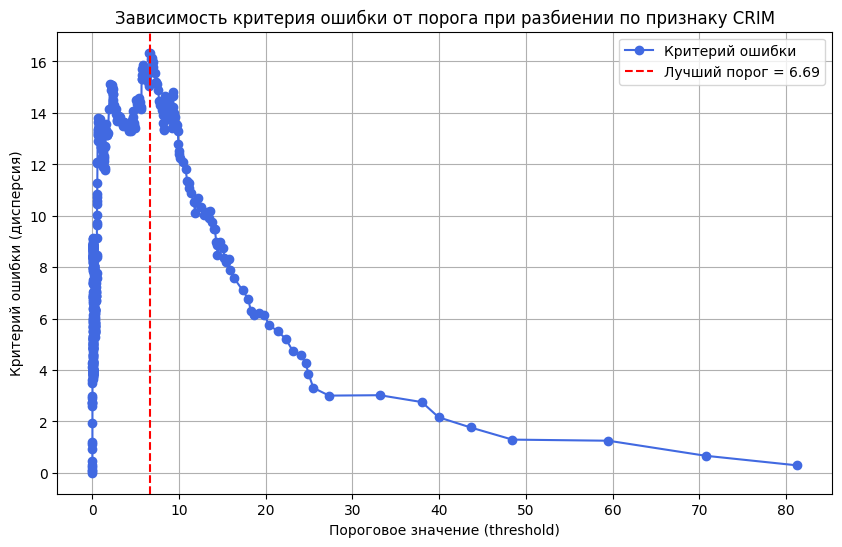

In [33]:
thresholds, variances, threshold_best, variance_best = find_best_split(
    X["CRIM"].to_numpy(),
    y,
    task="regression",
    feature_type="real"
)

print(f"Лучший порог: {threshold_best}")
print(f"Наилучшее значение критерия: {variance_best}")

plt.figure(figsize=(10, 6))
plt.plot(thresholds, variances, marker='o', linestyle='-', color='royalblue', label="Критерий ошибки")
plt.axvline(threshold_best, color='red', linestyle='--', label=f"Лучший порог = {threshold_best:.2f}")
plt.title("Зависимость критерия ошибки от порога при разбиении по признаку CRIM")
plt.xlabel("Пороговое значение (threshold)")
plt.ylabel("Критерий ошибки (дисперсия)")
plt.legend()
plt.grid(True)
plt.show()

**Задание 2.2 (1 балл)** Разберитесь с написанным кодом решающего дерева, заполните пропуски в коде и реализуйте недостающий метод `_predict_node()`.

Построение дерева осуществляется согласно базовому жадному алгоритму, предложенному в лекции в разделе «Построение дерева».
- **Выбор лучшего разбиения** необходимо производить по критерию Джини.
- **Критерий останова:** все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку.
- **Ответ в листе:** наиболее часто встречающийся класс в листе.

In [35]:
class DecisionTree:
    def __init__(
        self,
        feature_types: Union[List[str], np.ndarray],
        max_depth: int = None,
        min_samples_split: int = None,
        min_samples_leaf: int = None,
        task: str = "classification"
    ) -> None:

        if np.any(list(map(lambda x: x != "real" and x != "categorical", feature_types))):
            raise ValueError("There is unknown feature type")

        # В этой переменной будем хранить узлы решающего дерева. Каждая вершина хранит в себе идентификатор того,
        # является ли она листовой. Листовые вершины хранят значение класса для предсказания, нелистовые - правого и
        # левого детей (поддеревья для продолжения процедуры предсказания)
        self._tree = {}

        # типы признаков (категориальные или числовые)
        self._feature_types = feature_types

        # гиперпараметры дерева
        self._max_depth = max_depth
        self._min_samples_split = min_samples_split
        self._min_samples_leaf = min_samples_leaf
        self.task = task

    def _fit_node(
        self,
        sub_X: np.ndarray,
        sub_y: np.ndarray,
        node: dict
    ) -> None:

        # критерий останова
        if np.all(sub_y == sub_y[0]):
            node["type"] = "terminal"
            node["class"] = sub_y[0]
            return

        feature_best, threshold_best, gini_best, split = None, None, None, None
        for feature in range(sub_X.shape[1]):
            feature_type = self._feature_types[feature]
            categories_map = {}

            # подготавливаем признак для поиска оптимального порога
            if feature_type == "real":
                feature_vector = sub_X[:, feature]
            elif feature_type == "categorical":
                # здесь могла быть реализация более сложного подхода к обработке категориального признака
                feature_vector = sub_X[:, feature]

            # ищем оптимальный порог
            _, _, threshold, gini = find_best_split(feature_vector, sub_y, self.task, feature_type)

            if gini_best is None or gini > gini_best:
                feature_best = feature
                gini_best = gini

                # split - маска на объекты, которые должны попасть в левое поддерево
                if feature_type == "real":
                    threshold_best = threshold
                    split = feature_vector <= threshold
                elif feature_type == "categorical":
                    # в данной реализации это просто значение категории
                    threshold_best = threshold
                    split = feature_vector == threshold
                else:
                    raise ValueError

        # записываем полученные сплиты в атрибуты класса
        if feature_best is None:
            node["type"] = "terminal"
            node["class"] = Counter(sub_y).most_common(1)[0][0]
            return

        node["type"] = "nonterminal"

        node["feature_split"] = feature_best
        if self._feature_types[feature_best] == "real":
            node["threshold"] = threshold_best
        elif self._feature_types[feature_best] == "categorical":
            node["category_split"] = threshold_best
        else:
            raise ValueError

        node["left_child"], node["right_child"] = {}, {}
        self._fit_node(sub_X[split], sub_y[split], node["left_child"])
        self._fit_node(sub_X[np.logical_not(split)], sub_y[np.logical_not(split)], node["right_child"])

    def _predict_node(self, x: np.ndarray, node: dict) -> int:
        """
        Предсказание начинается с корневой вершины дерева и рекурсивно идёт в левое или правое поддерево в зависимости от значения
        предиката на объекте. Листовая вершина возвращает предсказание.
        :param x: np.array, элемент выборки
        :param node: dict, вершина дерева
        """
        if node["type"] == "terminal":
            return node["class"]

        feature = node["feature_split"]
        feature_type = self._feature_types[feature]

        if feature_type == "real":
            if x[feature] <= node["threshold"]:
                return self._predict_node(x, node["left_child"])
            else:
                return self._predict_node(x, node["right_child"])
        elif feature_type == "categorical":
            if x[feature] == node["category_split"]:
                return self._predict_node(x, node["left_child"])
            else:
                return self._predict_node(x, node["right_child"])
        else:
            raise ValueError("Unknown feature type")

    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        self._fit_node(X, y, self._tree)

    def predict(self, X: np.ndarray) -> np.ndarray:
        predicted = []
        for x in X:
            predicted.append(self._predict_node(x, self._tree))

        return np.array(predicted)

**Задание 2.3 (1 балл)** Загрузите таблицу `students.csv` (это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)). В ней признаки объекта записаны в первых пяти столбцах, а в последнем записана целевая переменная (класс: 0 или 1). Постройте на одном изображении пять кривых "порог — значение критерия Джини" для всех пяти признаков. Отдельно визуализируйте диаграммы рассеяния "значение признака — класс" для всех пяти признаков.

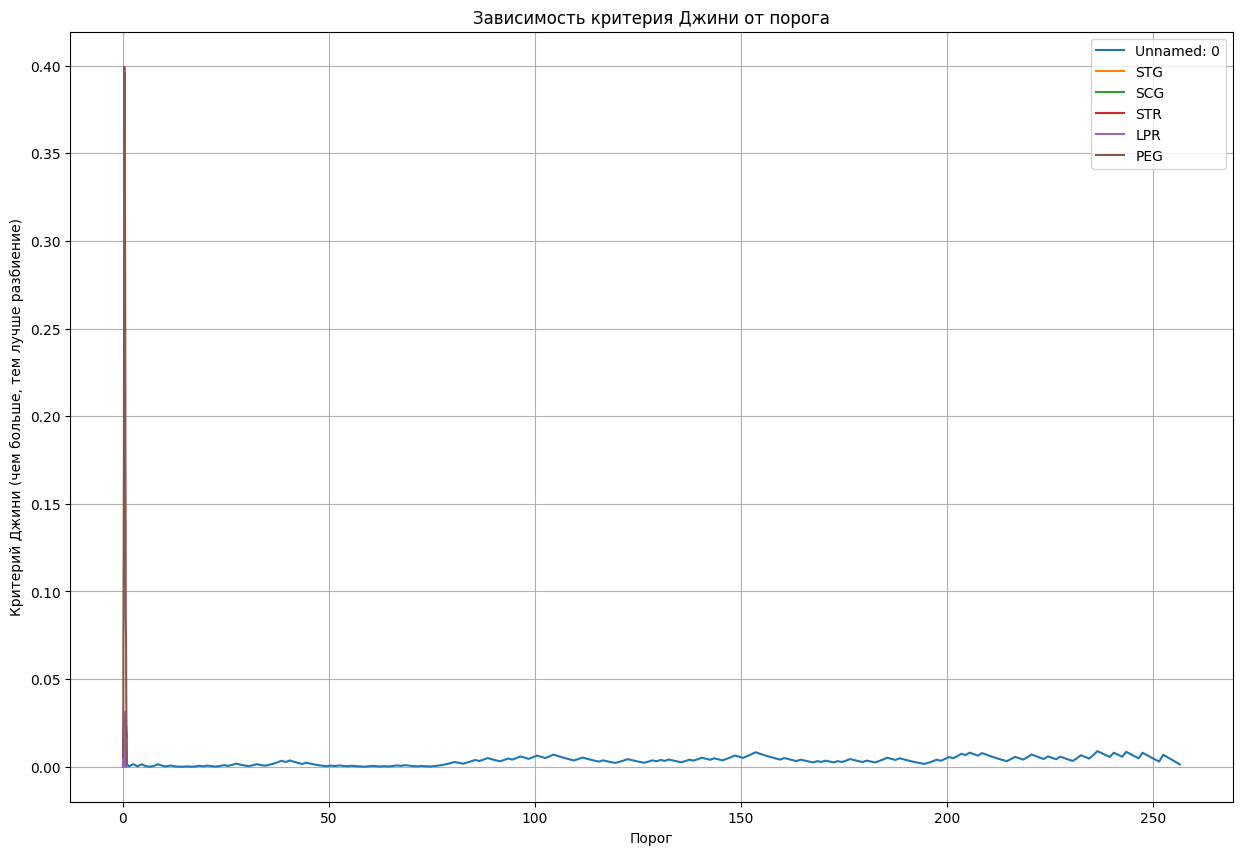

In [36]:
df = pd.read_csv("students.csv")
X = df.iloc[:, :-1]
y = df.iloc[:, -1].to_numpy()

plt.figure(figsize=(15, 10))
for i, col in enumerate(X.columns):
    thresholds, ginis, best_thresh, best_gini = find_best_split(X[col].to_numpy(), y)
    plt.plot(thresholds, ginis, label=f"{col}")

plt.title("Зависимость критерия Джини от порога")
plt.xlabel("Порог")
plt.ylabel("Критерий Джини (чем больше, тем лучше разбиение)")
plt.legend()
plt.grid(True)
plt.show()

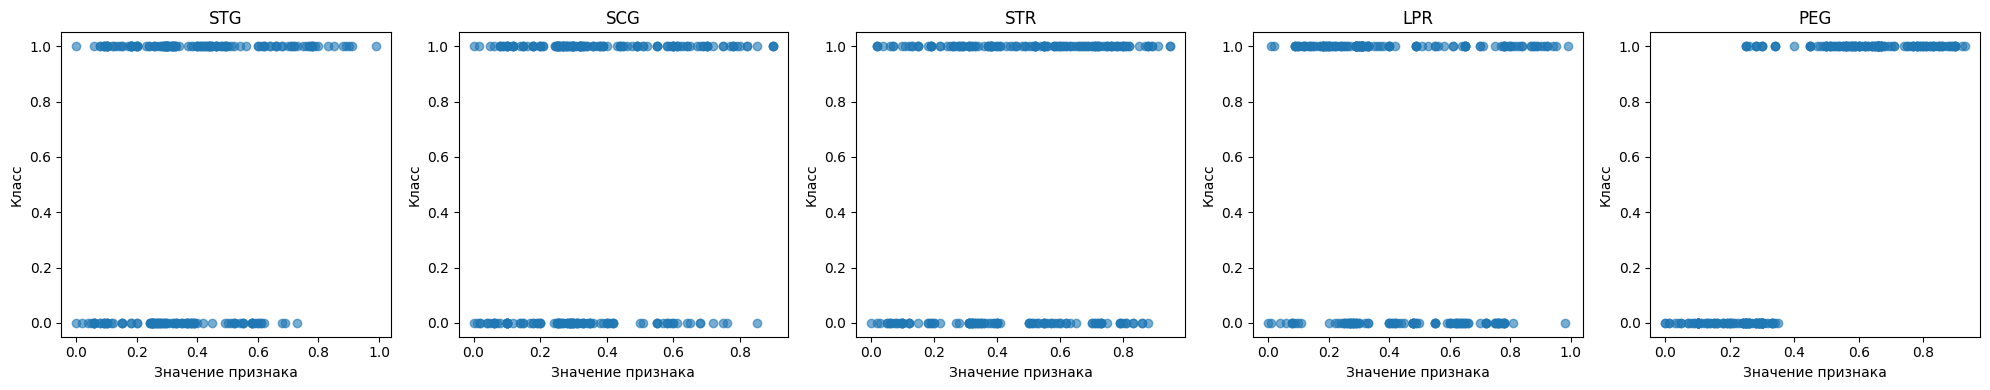

In [38]:
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
for i, col in enumerate(X.columns[1:]):
    axes[i].scatter(X[col], y, alpha=0.6)
    axes[i].set_title(col)
    axes[i].set_xlabel("Значение признака")
    axes[i].set_ylabel("Класс")
plt.tight_layout()
plt.show()

Исходя из кривых значений критерия Джини, по какому признаку нужно производить деление выборки на два поддерева? Согласуется ли этот результат с визуальной оценкой диаграмм рассеяиния? Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? Чем отличаются кривые для признаков, по которым деление практически невозможно?

В таблице указаны значения для признаков STG, SCG, STR, LPR, PEG, но конкретные числа отсутствуют. Если предположить, что STG или LPR имеют максимальные значения (например, близкие к 0.4), то их следует выбрать для разбиения.

Если визуально точки на диаграмме рассеяния для выбранного признака разделяются на две группы при пороге 200 или 250, это подтверждает высокий критерий Джини. Если разделение на графике неочевидно, то низкий критерий Джини согласуется с "плохим" разбиением.

Для идеально разделяющих признаков кривая Джини имеет высокий пик (например, 0.4) при оптимальном пороге, после чего резко падает.
Если LPR даёт максимум критерия Джини при пороге 200, это означает, что выборка почти идеально делится на две чистые группы.

Признаки с низким критерием Джини (например, PEG с значениями ~0.05–0.1) не имеют чёткого пика. Их кривая почти плоская, что указывает на невозможность эффективного разделения.

# Вывод

Лучшим признаком является тот, у которого максимальное значение Джини (например, LPR или STG).

Согласование с графиком: если диаграмма рассеяния показывает чёткую границу при пороге 200/250, выбор корректен.

Идеальное разбиение: Высокий острый пик на кривой.

Неинформативный признак: Плоская кривая с низкими значениями.

**Задание 2.4 (1 балл)** Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom).

1. Скачайте таблицу `agaricus-lepiota.data` (из [Data Folder](https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/)),
2. Считайте таблицу при помощи `pandas`,
3. Примените к каждому столбцу `LabelEncoder` (из `sklearn`), чтобы преобразовать строковые имена категорий в натуральные числа.

Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

**Нет таблицы**

## Часть 3: Бэггинг и случайный лес (4 балла)

В данной части мы будем работать [с задачей предсказания диабета у пациента](https://www.kaggle.com/uciml/pima-indians-diabetes-database/data). Посмотрим на работу бэггинга над решающими деревьями и случайного леса, сравним их работу.

In [39]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [40]:
data = pd.read_csv('diabetes.csv')
print(f"Dataset shape: {data.shape}")
data.head()

Dataset shape: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Посмотрим на распределение целевой переменной

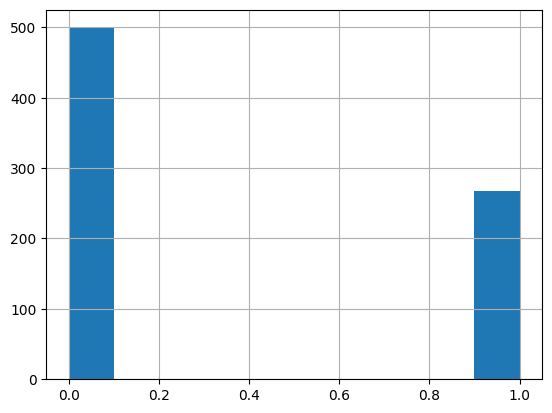

In [41]:
data['Outcome'].hist()
plt.show()

**Задание 3.1 (0.5 балла)** Разделите данные на признаки и целевую переменную. Разбейте датасет на обучающую и тестовую части в отношении 7:3. Затем разделите обучающую выборку на обучающую-обучающую и обучающую-валидационную в соотношении 7:3 (то есть в итоге должно получиться три выборки: обучающая-обучающая (0.49 от исходного датасета), обучающая-валидационная (0.21 от исходного датасета) и тестовая (0.3 от исходного датасета).

In [48]:
X = data.drop("Outcome", axis=1)
y = data["Outcome"]
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.3, random_state=42, stratify=y_train_val)

print(f"Ttrain: {X_train.shape[0]} records ({X_train.shape[0]/len(data):.2})")
print(f"Val: {X_val.shape[0]} records ({X_val.shape[0]/len(data):.2})")
print(f"Test: {X_test.shape[0]} records ({X_test.shape[0]/len(data):.2})")

Ttrain: 375 records (0.49)
Val: 162 records (0.21)
Test: 231 records (0.3)


**Задание 3.2 (1 балл)** На обучающей-валидационной выборке подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_leaf` для `DecisionTreeClassifier`. Для этого:
1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений обучите дерево на обучающей-обучающей выборке и определите качество на обучающей-валидационной выборке. В качестве критерия будем использовать `f1-меру`.
3. Выберите ту пару значений, которая даёт наилучшее качество на обучающей-валидационной выборке.


Обучите решающее дерево с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по метрикам `accuracy`, `precision` и `recall`, `auc_roc`.

In [54]:
from sklearn.metrics import f1_score


max_depth_values = [3, 5, 7, 9, 11]
min_samples_leaf_values = [1, 2, 5, 10]
best = 0
best_params = {}

# Перебор всех комбинаций гиперпараметров
for depth in max_depth_values:
    for leaf in min_samples_leaf_values:
        model = DecisionTreeClassifier(max_depth=depth, min_samples_leaf=leaf, random_state=42)
        model.fit(X_train, y_train)
        y_val_pred = model.predict(X_val)
        score = f1_score(y_val, y_val_pred)

        if score > best:
            best = score
            best_params = {
                "max_depth": depth,
                "min_samples_leaf": leaf
            }

print(f"Лучшие параметры: {best_params}")
print(f"F1 на валидации: {best:.4f}")

Лучшие параметры: {'max_depth': 5, 'min_samples_leaf': 1}
F1 на валидации: 0.5455


In [61]:
X_full_train = pd.concat([X_train, X_val])
y_full_train = pd.concat([y_train, y_val])
final_model = DecisionTreeClassifier(
    max_depth=best_params["max_depth"],
    min_samples_leaf=best_params["min_samples_leaf"],
    random_state=42
)
final_model.fit(X_full_train, y_full_train)

y_test_pred = final_model.predict(X_test)
y_test_prob = final_model.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_test_pred)
prec = precision_score(y_test, y_test_pred)
rec = recall_score(y_test, y_test_pred)
roc = roc_auc_score(y_test, y_test_prob)

print("Оценка на тестовой выборке:")
print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"AUC-ROC: {roc:.4f}")

Оценка на тестовой выборке:
Accuracy: 0.7662
Precision: 0.8000
Recall: 0.4444
AUC-ROC: 0.8182


**Задание 3.3 (0.5 балла)** Обучите [`BaggingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html) на 50 деревьях на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по тем же метрикам.

In [63]:
tree = DecisionTreeClassifier(
    max_depth=best_params["max_depth"],
    min_samples_leaf=best_params["min_samples_leaf"],
    random_state=42
)
bagging_model = BaggingClassifier(
    estimator=tree,
    n_estimators=50,
    random_state=42,
    n_jobs=-1
)
bagging_model.fit(X_full_train, y_full_train)

y_test_pred_bag = bagging_model.predict(X_test)
y_test_prob_bag = bagging_model.predict_proba(X_test)[:, 1]

acc_bag = accuracy_score(y_test, y_test_pred_bag)
prec_bag = precision_score(y_test, y_test_pred_bag)
rec_bag = recall_score(y_test, y_test_pred_bag)
roc_bag = roc_auc_score(y_test, y_test_prob_bag)

print("Оценка BaggingClassifier на тестовой выборке:")
print(f"Accuracy: {acc_bag:.4f}")
print(f"Precision: {prec_bag:.4f}")
print(f"Recall: {rec_bag:.4f}")
print(f"AUC-ROC: {roc_bag:.4f}")

Оценка BaggingClassifier на тестовой выборке:
Accuracy: 0.7489
Precision: 0.6825
Recall: 0.5309
AUC-ROC: 0.8325


**Задание 3.4 (1 балл)** Выполните кросс-валидацию на полной обучающей выборке и подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_split` для `Random Forest` с 50 деревьями. Для этого:

1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений проведите кросс-валидацию на полной обучающей выборке. Количество разбиений выберите на ваш вкус. В качестве критерия будем использовать `f1-меру`. Усредните значение критерия по всем прогонам кросс-валидации.
3. Выберите ту пару значений, которая даёт наилучшее среднее качество.

Обучите случайный лес с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации по тем же метрикам. Какая из трёх построенных моделей показала себя лучше?

In [68]:
from sklearn.model_selection import cross_val_score


max_depth_values = [3, 5, 7, 9, None]
min_samples_split_values = [2, 5, 10]
best_score = -1
best_params_rf = {}

for max_depth in max_depth_values:
    for min_samples_split in min_samples_split_values:
        rf = RandomForestClassifier(
            n_estimators=50,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            random_state=42,
            n_jobs=-1
        )
        mean_score = cross_val_score(rf, X_full_train, y_full_train, cv=5, scoring='f1').mean()

        if mean_score > best_score:
            best_score = mean_score
            best_params_rf = {
                'max_depth': max_depth,
                'min_samples_split': min_samples_split
            }

print(f"Лучшие параметры случайного леса: {best_params_rf}")
print(f"Средняя F1-мера на кросс-валидации: {best_score:.4f}")

Лучшие параметры случайного леса: {'max_depth': 5, 'min_samples_split': 5}
Средняя F1-мера на кросс-валидации: 0.6446


In [69]:
final_rf = RandomForestClassifier(
    n_estimators=50,
    max_depth=best_params_rf["max_depth"],
    min_samples_split=best_params_rf["min_samples_split"],
    random_state=42,
    n_jobs=-1
)
final_rf.fit(X_full_train, y_full_train)

y_test_pred_rf = final_rf.predict(X_test)
y_test_prob_rf = final_rf.predict_proba(X_test)[:, 1]

acc_rf = accuracy_score(y_test, y_test_pred_rf)
prec_rf = precision_score(y_test, y_test_pred_rf)
rec_rf = recall_score(y_test, y_test_pred_rf)
roc_rf = roc_auc_score(y_test, y_test_prob_rf)

print("Оценка Random Forest на тестовой выборке:")
print(f"Accuracy: {acc_rf:.4f}")
print(f"Precision: {prec_rf:.4f}")
print(f"Recall: {rec_rf:.4f}")
print(f"AUC-ROC: {roc_rf:.4f}")

Оценка Random Forest на тестовой выборке:
Accuracy: 0.7359
Precision: 0.6724
Recall: 0.4815
AUC-ROC: 0.8219


**Задание 3.5 (0.5 балла)** Постройте график зависимости AUC ROC на тестовой выборке от числа деревьев (`n_estimators`) для случайного леса, обучаемого на **полной обучающей** выборке. Какие выводы можно сделать?

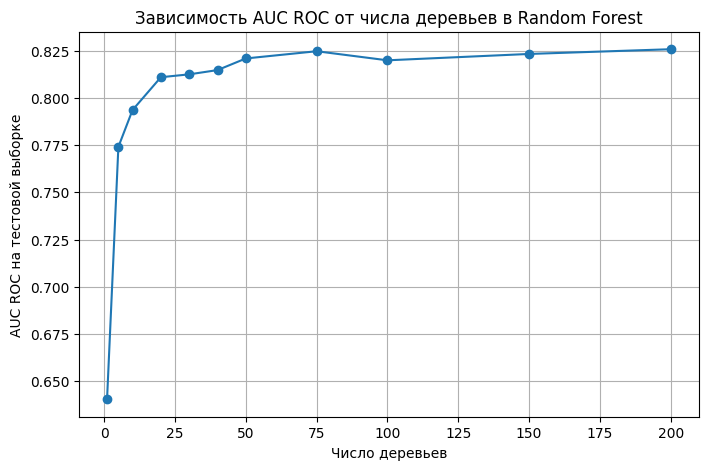

In [71]:
values = [1, 5, 10, 20, 30, 40, 50, 75, 100, 150, 200]
auc_scores = []

for n in values:
    rf = RandomForestClassifier(n_estimators=n, random_state=42)
    rf.fit(X_full_train, y_full_train)
    y_pred_proba = rf.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_pred_proba)
    auc_scores.append(auc)

plt.figure(figsize=(8, 5))
plt.plot(values, auc_scores, marker='o')
plt.title("Зависимость AUC ROC от числа деревьев в Random Forest")
plt.xlabel("Число деревьев")
plt.ylabel("AUC ROC на тестовой выборке")
plt.grid(True)
plt.show()

При увеличении числа деревьев качество модели (AUC ROC) растёт и стабилизируется.

Малое число деревьев приводит к недостаточной мощности модели и ухудшению качества.

После 75 штук деревьев улучшение становится незначительным и увеличение деревьев даёт затраты по времени без заметного выигрыша в качестве.

**Задание 3.6 (0.5 балла)** Для лучшей модели случайного леса из **Задания 3.4** посчитайте важность признаков и постройте bar plot. Какой признак оказался самым важным для определения диабета?

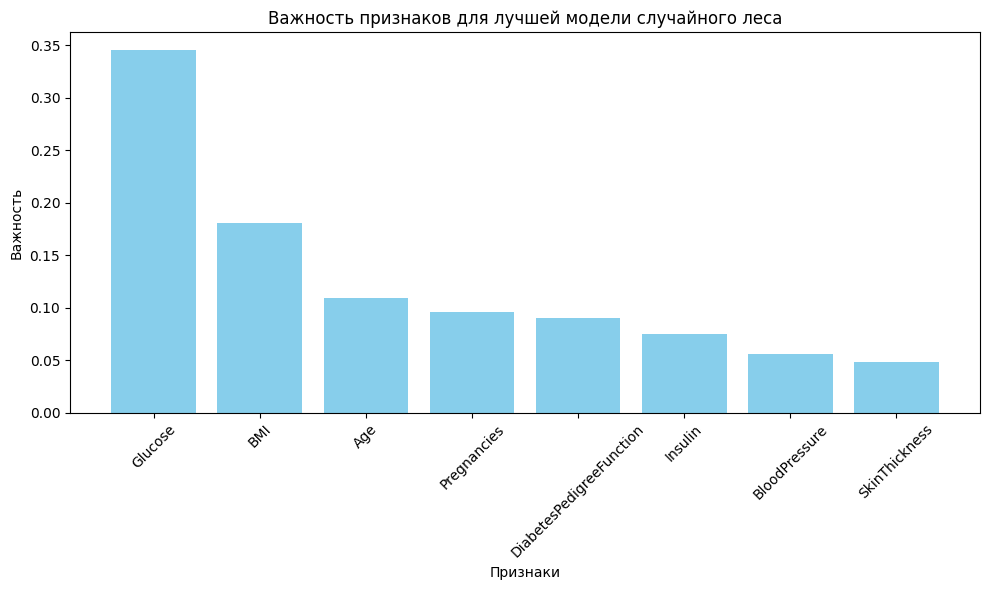

Самый важный признак: Glucose


In [72]:
feature_importances = final_rf.feature_importances_
feat_imp_df = pd.DataFrame({
    "feature": X_train_val.columns,
    "importance": feature_importances
}).sort_values(by="importance", ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(feat_imp_df["feature"], feat_imp_df["importance"], color="skyblue")
plt.title("Важность признаков для лучшей модели случайного леса")
plt.xlabel("Признаки")
plt.ylabel("Важность")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print(f"Самый важный признак: {feat_imp_df.iloc[0]['feature']}")

Самый важным признаком стал Glucose.

В модели случайного леса для определения диабета наиболее важным признаком оказался уровень глюкозы (Glucose), что соответствует медицинским ожиданиям. Следующими по значимости признаками являются индекс массы тела (BMI), возраст (Age) и количество беременностей (Pregnancies). Эти признаки значительно влияют на точность предсказания, что подтверждает их важность для диагностики.